# Problem Statement

We have to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv


## Importing Libraries

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud, STOPWORDS
import missingno as msno
import nltk
import re
import string
from keras.preprocessing.sequence import pad_sequences
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Importing Datasets

In [3]:
train = pd.read_csv(r'/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv(r'/kaggle/input/nlp-getting-started/test.csv')

In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
print(train.shape, test.shape)

(7613, 5) (3263, 4)


## Checking the missing values

In [7]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

## Percentage of Missing Values

In [9]:
print("Percentage of keywords missing in train data:", (len(train[train['keyword'].isnull()==True])/train.shape[0])*100,"%")
print("Percentage of keywords missing in test data:", (len(test[test['keyword'].isnull()==True])/test.shape[0])*100,"%")
print("Percentage of location missing in train data:", (len(train[train['location'].isnull()==True])/train.shape[0])*100,"%")
print("Percentage of location missing in test data:", (len(test[test['location'].isnull()==True])/test.shape[0])*100,"%")

Percentage of keywords missing in train data: 0.8012610009194797 %
Percentage of keywords missing in test data: 0.796812749003984 %
Percentage of location missing in train data: 33.27203467752528 %
Percentage of location missing in test data: 33.86454183266932 %


As percentage of missing values for both keyword and location are equal for train and test data. So, it may be concluded that both are taken from the same sample

## Visualizing Most Repeated Words using WordCloud

In [10]:
stopwords = set(STOPWORDS)
def word_cloud(data, title=None):
    cloud = WordCloud(background_color = 'black',
                     stopwords = stopwords,
                     max_words = 200,
                     max_font_size = 40,
                     scale = 3).generate(str(data))
    fig = plt.figure(figsize=(15,15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.25)
        plt.imshow(cloud)
        plt.show()

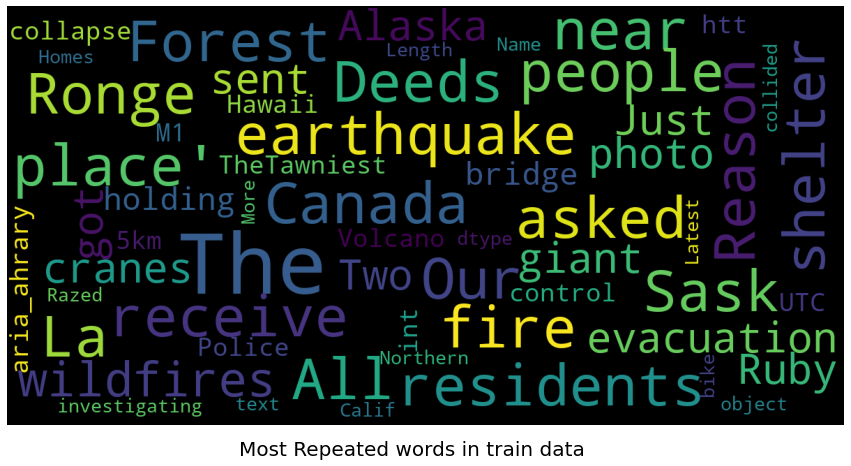

In [11]:
word_cloud(train['text'],'Most Repeated words in train data')

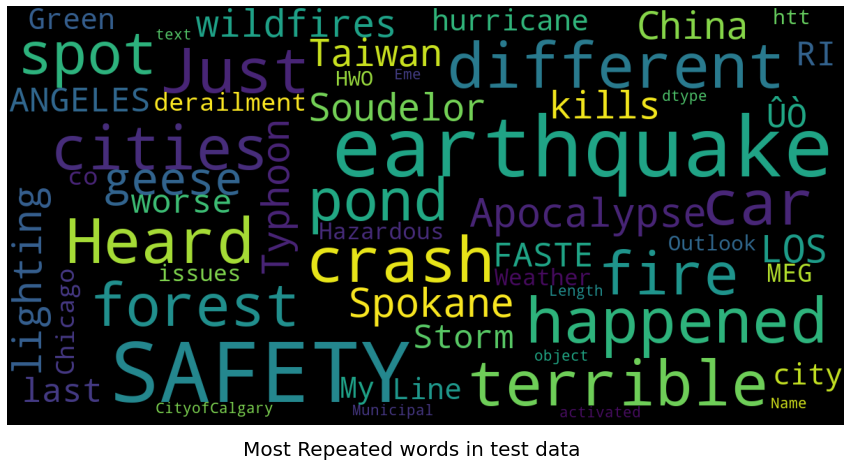

In [12]:
word_cloud(test['text'],'Most Repeated words in test data')

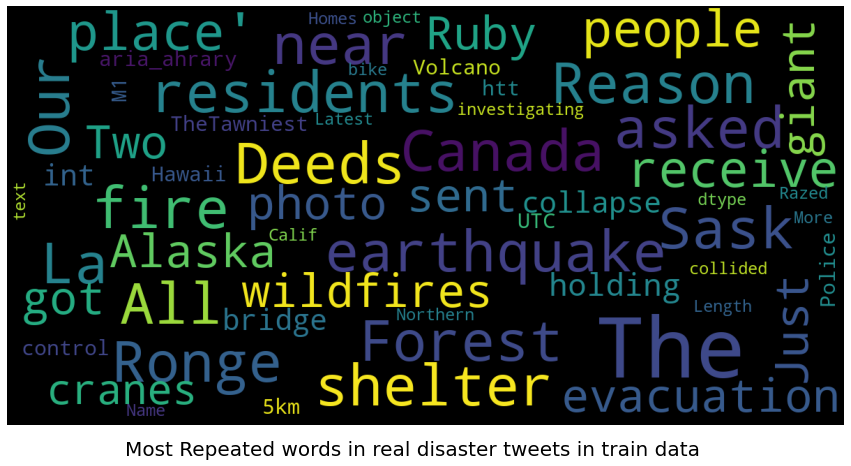

In [14]:
word_cloud(train[train['target']==1]['text'],'Most Repeated words in real disaster tweets in train data')

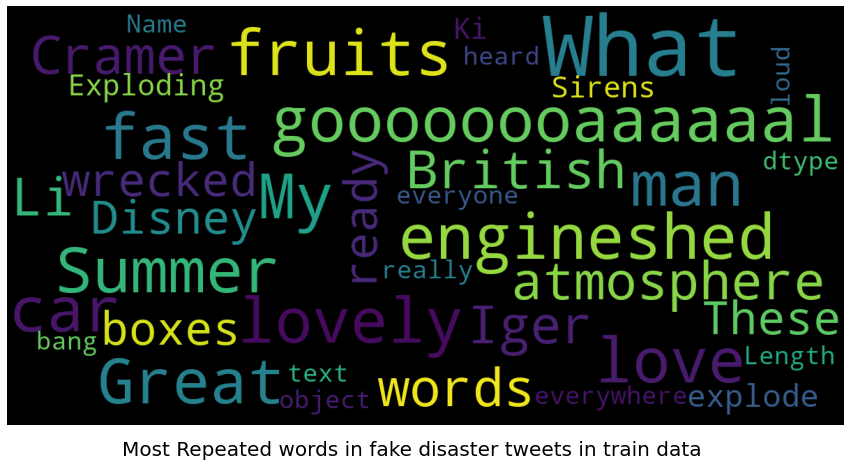

In [15]:
word_cloud(train[train['target']==0]['text'],'Most Repeated words in fake disaster tweets in train data')

# Visualizing Counts for each categories of tweet

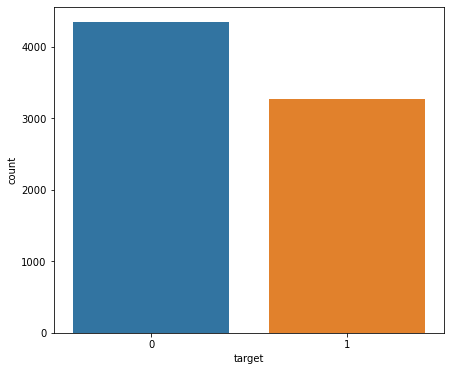

In [13]:
plt.figure(figsize=(7,6))
sns.countplot(train['target'])

Looks like a Balanced Dataset

## Visualizing keyword repitition in each disaster and non-disaster tweets

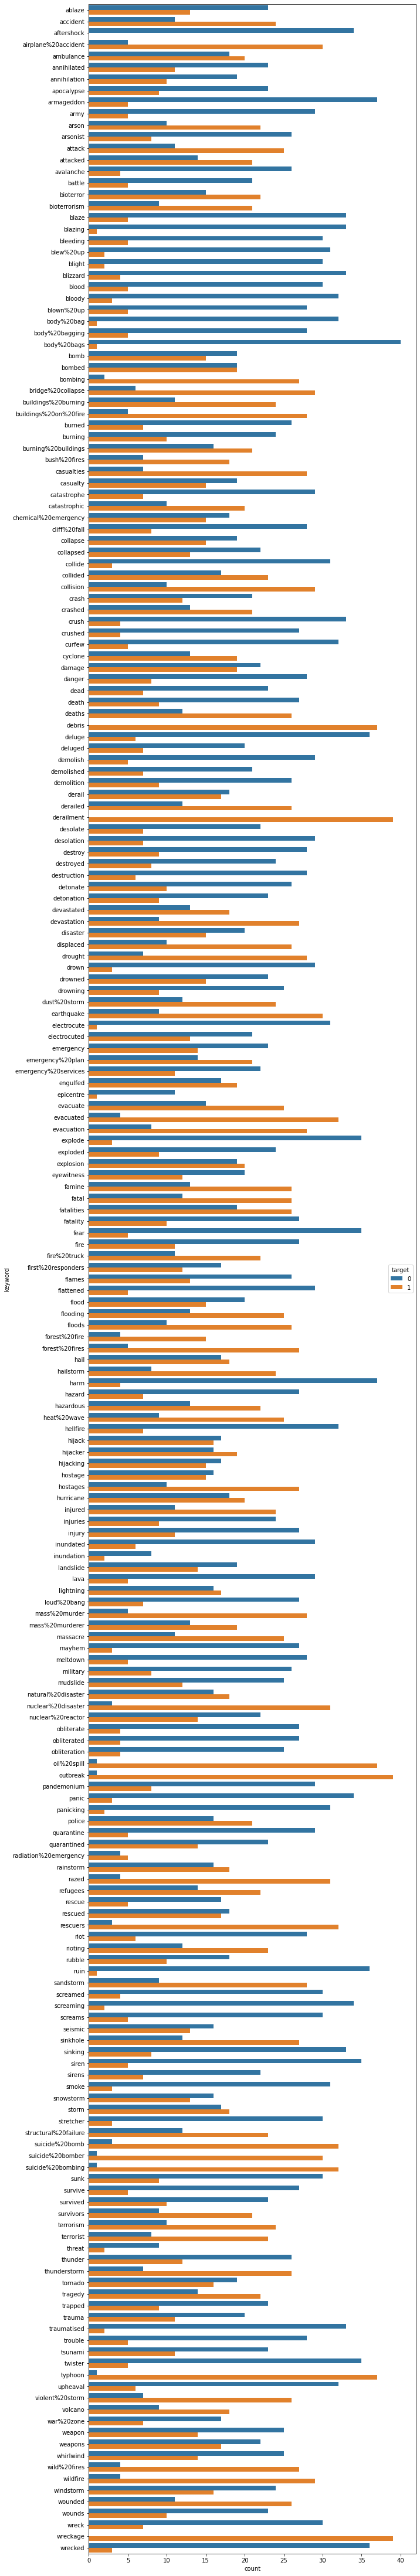

In [64]:
plt.figure(figsize=(10,80))
sns.countplot(y = 'keyword', hue = 'target', data = train)

## Data Cleaning

### Number of characters in a tweet

Text(0.5, 0.98, 'Characters in tweets')

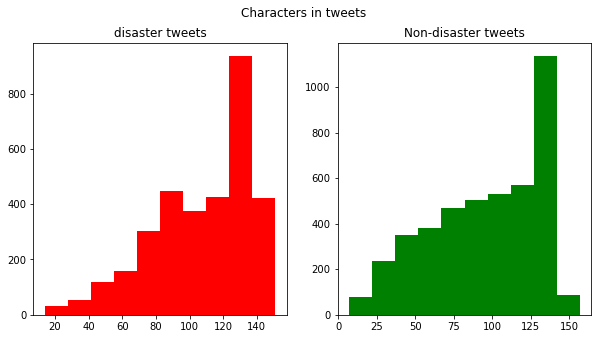

In [17]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Characters in tweets')

### Number of words in a tweet

Text(0.5, 0.98, 'Words in a tweet')

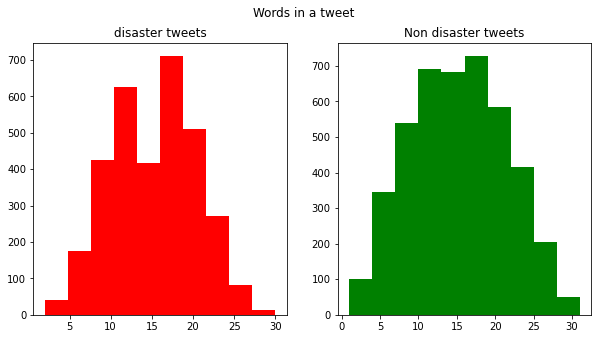

In [18]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_words = train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_words, color='red')
ax1.set_title('disaster tweets')
tweet_words = train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_words, color='green')
ax2.set_title('Non disaster tweets')
fig.suptitle('Words in a tweet')

### Average Word Length in a tweet

Text(0.5, 0.98, 'Average word length in each tweet')

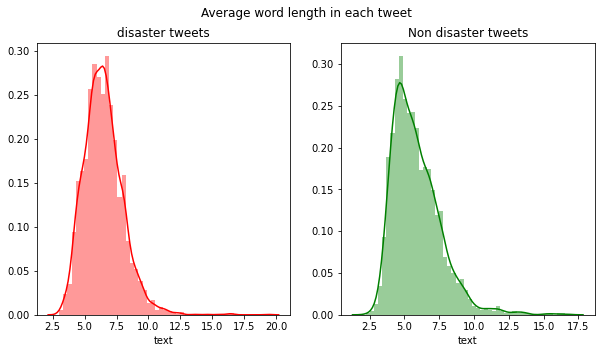

In [19]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
tweet_words = train[train['target']==1]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(tweet_words.map(lambda x: np.mean(x)), color='red')
plt.title('disaster tweets')
plt.subplot(1,2,2)
tweet_words = train[train['target']==0]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(tweet_words.map(lambda x: np.mean(x)), color='green')
plt.title('Non disaster tweets')
plt.suptitle('Average word length in each tweet')

## Data Cleaning

### Removing emojis

In [20]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [21]:
train['text'] = train['text'].apply(lambda x: remove_emoji(x))
test['text'] = test['text'].apply(lambda x: remove_emoji(x))

In [22]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

In [23]:
from nltk.corpus import stopwords
for i in range(len(train.text)):
    train['text'][i] = re.sub('@[a-zA-Z0-9_]+', ' ', train['text'][i]) # Removing the text starting with @
    train['text'][i] = re.sub('\W', ' ', train['text'][i]) # Removing non alphanumeric text
    train['text'][i] = re.sub('\d', ' ', train['text'][i]) # Removing numeric text
    train['text'][i] = re.sub('\[a-zA-Z0-9_.]+', ' ', train['text'][i]) # Removing text starting with /
    train['text'][i] = re.sub('#[a-zA-Z0-9_]+', ' ', train['text'][i]) # Removing text starting with #
    train['text'][i] = re.sub('http://[a-zA-Z0-9_./]+', ' ', train['text'][i]) # Removing text having http in it
    train['text'][i] = re.sub('[^a-zA-Z0-9]', ' ', train['text'][i]) # Removing everything other than alphanumeic text
    train['text'][i] = train['text'][i].lower() # Taking text into lowercase
    train['text'][i] = train['text'][i].split() # Splitting sentences into words
    train['text'][i] = [lemma.lemmatize(word) for word in train['text'][i] if word not in set(stopwords.words('english'))]
    train['text'][i] = ' '.join(train['text'][i])

In [24]:
for i in range(len(test.text)):
    test['text'][i] = re.sub('@[a-zA-Z0-9_]+', ' ', test['text'][i]) # Removing the text starting with @
    test['text'][i] = re.sub('\W', ' ', test['text'][i]) # Removing non alphanumeric text
    test['text'][i] = re.sub('\d', ' ', test['text'][i]) # Removing numeric text
    test['text'][i] = re.sub('\[a-zA-Z0-9_.]+', ' ', test['text'][i]) # Removing text starting with /
    test['text'][i] = re.sub('#[a-zA-Z0-9_]+', ' ', test['text'][i]) # Removing text starting with #
    test['text'][i] = re.sub('http://[a-zA-Z0-9_./]+', ' ', test['text'][i]) # Removing text having http in it
    test['text'][i] = re.sub('[^a-zA-Z0-9]', ' ', test['text'][i]) # Removing everything other than alphanumeic text
    test['text'][i] = test['text'][i].lower() # Taking text into lowercase
    test['text'][i] = test['text'][i].split() # Splitting sentences into words
    test['text'][i] = [lemma.lemmatize(word) for word in test['text'][i] if word not in set(stopwords.words('english'))]
    test['text'][i] = ' '.join(test['text'][i])

## Taking out the text and labels out of train and test dataset

In [50]:
train_text = []
train_labels = []
for i in range(len(train['text'])):
    train_text.append(str(train.iloc[i,3]))
    train_labels.append(train.iloc[i,4])
test_text = []
for i in range(len(test['text'])):
    test_text.append(str(test.iloc[i,3]))

## Initializing parameters

In [51]:
embedding_dim = 32
max_length = 20
vocab_size = 15000
padding_type = 'post'
trunc_type = 'post'

## Tokenizing the text

In [52]:
tokenizer = Tokenizer(oov_token='<oov>', num_words = vocab_size)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(train_text)

## Padding text to make it of same length

In [53]:
padded_train = pad_sequences(sequences, maxlen = max_length , padding = padding_type, truncating = trunc_type)

## Applying padding to test data

In [54]:
test_sequences = tokenizer.texts_to_sequences(test['text'])
padded_test = pad_sequences(test_sequences, maxlen = max_length , padding = padding_type, truncating = trunc_type)

## Make training labels as numpy array as it is expected for the training

In [55]:
y = np.array(train_labels)
y.shape

(7613,)

## Splitting training data into train and validation sets

In [56]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(padded_train,y,test_size=0.05,random_state=12)
print("Shape of X_train: " + str(X_train.shape))
print("Shape of y_train: " + str(len(y_train)))
print("Shape of X_val: " + str(X_val.shape))
print("Shape of y_val: " + str(len(y_val)))

Shape of X_train: (7232, 20)
Shape of y_train: 7232
Shape of X_val: (381, 20)
Shape of y_val: 381


## Initializing the Model

In [57]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(units=6, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid")    
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 256)           3840000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 1542      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 3,841,549
Trainable params: 3,841,549
Non-trainable params: 0
_________________________________________________________________


## Initializing the optimizer and metric 

In [58]:
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.RMSprop(lr=4*0.0001), metrics = ['acc'])

## Initializing Callback

In [59]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.3, verbose=1,
                              patience=2, min_lr=0.00000001)

## Fitting the model

In [60]:
history = model.fit(X_train, y_train, epochs = 10, validation_data = (X_val, y_val),callbacks=[reduce_lr], verbose = 2)

Train on 7232 samples, validate on 381 samples
Epoch 1/10
7232/7232 - 5s - loss: 0.6690 - acc: 0.6659 - val_loss: 0.6381 - val_acc: 0.6640
Epoch 2/10
7232/7232 - 4s - loss: 0.5848 - acc: 0.7355 - val_loss: 0.5646 - val_acc: 0.7428
Epoch 3/10
7232/7232 - 4s - loss: 0.4909 - acc: 0.7960 - val_loss: 0.5065 - val_acc: 0.7664
Epoch 4/10
7232/7232 - 4s - loss: 0.4148 - acc: 0.8341 - val_loss: 0.4704 - val_acc: 0.7927
Epoch 5/10
7232/7232 - 4s - loss: 0.3694 - acc: 0.8502 - val_loss: 0.4629 - val_acc: 0.7900
Epoch 6/10
7232/7232 - 4s - loss: 0.3427 - acc: 0.8592 - val_loss: 0.4608 - val_acc: 0.8058
Epoch 7/10
7232/7232 - 4s - loss: 0.3262 - acc: 0.8667 - val_loss: 0.4589 - val_acc: 0.8058
Epoch 8/10
7232/7232 - 4s - loss: 0.3151 - acc: 0.8720 - val_loss: 0.4605 - val_acc: 0.8084
Epoch 9/10
7232/7232 - 4s - loss: 0.3051 - acc: 0.8764 - val_loss: 0.4570 - val_acc: 0.8163
Epoch 10/10
7232/7232 - 4s - loss: 0.2956 - acc: 0.8819 - val_loss: 0.4759 - val_acc: 0.7900


## Visualizing Training and validation sets loss and accuracy score

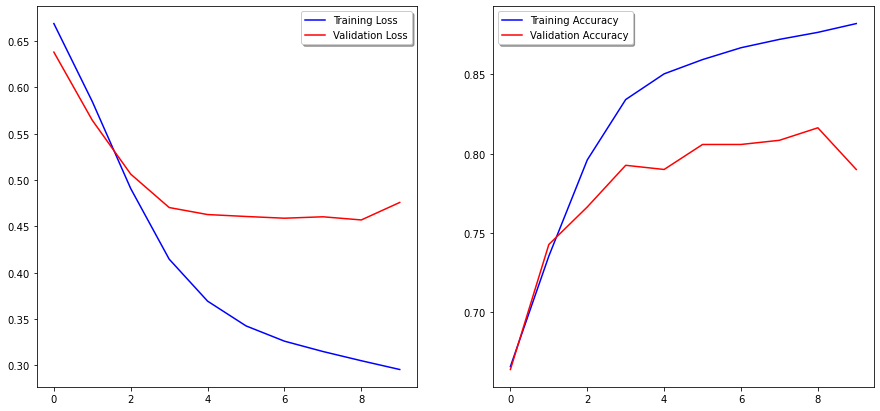

In [61]:
plt.figure(figsize=(15,7))
ax1 = plt.subplot(1,2,1)
ax1.plot(history.history['loss'], color='b', label='Training Loss') 
ax1.plot(history.history['val_loss'], color='r', label = 'Validation Loss',axes=ax1)
legend = ax1.legend(loc='best', shadow=True)
ax2 = plt.subplot(1,2,2)
ax2.plot(history.history['acc'], color='b', label='Training Accuracy') 
ax2.plot(history.history['val_acc'], color='r', label = 'Validation Accuracy')
legend = ax2.legend(loc='best', shadow=True)

## Predicting test data to output the tweet labels

In [63]:
y_pred = model.predict(padded_test)
model_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
model_submission['target'] = np.round(y_pred).astype('int')
model_submission.to_csv('model_submission6.csv', index=False)